In [32]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os, glob, math, re
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


Enquanto o random search é processado em paralelo, seguimos com a avaliação de fine-tuning de um dos LOOCV com os seguintes parâmetros:

**Hiperparâmetros selecionados:** 
* Épocas para o treinamento da saída Dense: 15
* Taxa de aprendizagem para a saída Dense: 0.0001
* Épocas para o fine-tuning: 10
* Taxa de aprendizagem no fine-tuning: 0.0003
* Camadas descongeladas e treinadas no fine-tuning: 12

In [33]:
diretório = 'reports\\fits_csv\\hdep_15\\ftep_10\\uf_12\\hdlr_0.0001\\ft_lr0.0003'

# Relatório de treinamentos por fold

In [34]:
pattern = os.path.join(diretório, "*ft.csv")
out_dir = "reports\\fits_plot"
os.makedirs(out_dir, exist_ok=True)

csv_files = sorted(glob.glob(pattern))
print(f"Arquivos encontrados: {len(csv_files)}")

Arquivos encontrados: 35


In [35]:
# Função para encontrar os arquivos csv
def get_fold_id(fname):
    m = re.search(r"fold_(\d+)", os.path.basename(fname))
    return int(m.group(1)) if m else None

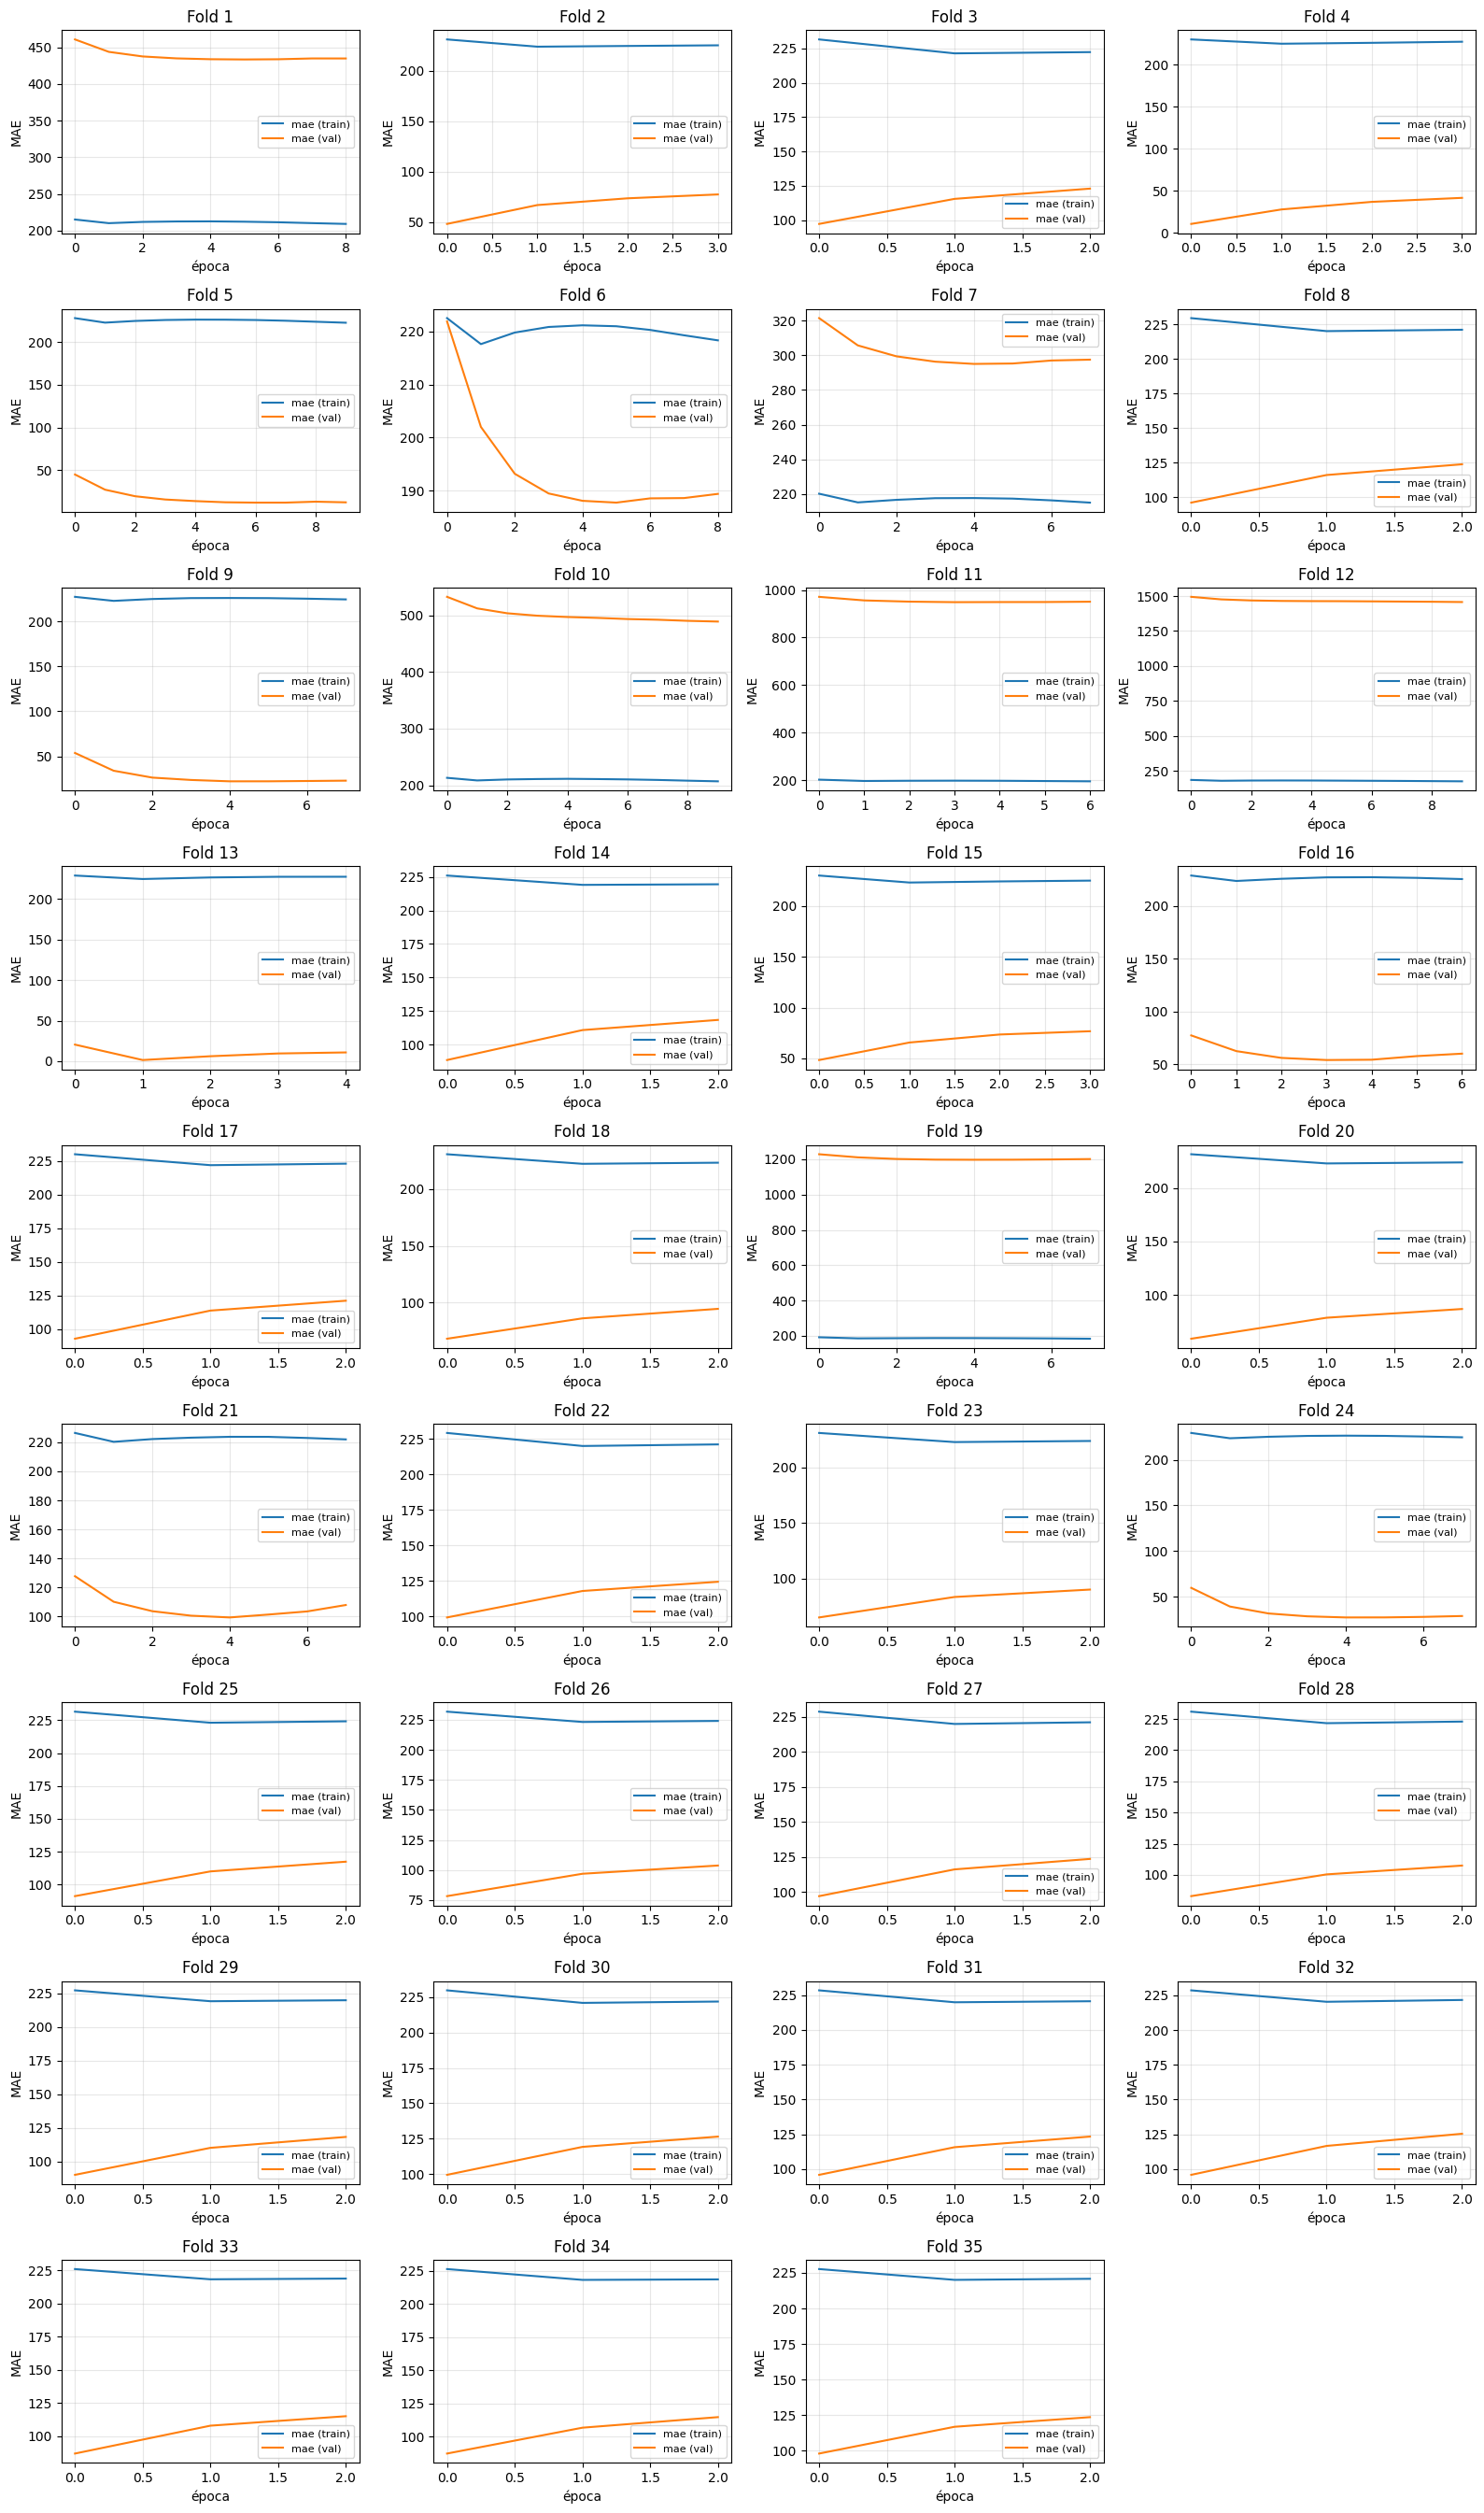

In [36]:
# grade de subplots
n = len(csv_files)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=False, sharey=False)
axes = axes.flatten() if n > 1 else [axes]

for ax in axes:
    ax.axis("off")

for idx, fpath in enumerate(csv_files):
    df = pd.read_csv(fpath)
    # Colunas típicas do CSVLogger: 'epoch','loss','mae','val_loss','val_mae'
    # Ajuste os nomes se tiver usado callback customizado (ex.: 'mae_loss','mae_val','mse_val')
    epoch = df["epoch"]
    y_tr = df["mae"]
    y_va = df["val_mae"]

    ax = axes[idx]
    ax.axis("on")
    if y_tr is not None:
        ax.plot(epoch, y_tr, label="mae (train)", color="#1f77b4")
    if y_va is not None:
        ax.plot(epoch, y_va, label="mae (val)", color="#ff7f0e")
    ax.set_xlabel("época")
    ax.set_ylabel("MAE")
    fold_id = get_fold_id(fpath)
    ax.set_title(f"Fold {fold_id if fold_id is not None else idx+1}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)

for j in range(idx+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "mae_per_fold.png"), dpi=150)
plt.show()

Observa-se:
* MAE de validação muito baixo em comparação ao de treino.
* As curvas de validação por fold são inerentemente ruidosas em LOOCV, pois cada validação baseia‑se em uma única observação.
* Na maioria dos folds houve pouca mudança no MAE de treino e leve oscilação no MAE de validação, coerente com o cenário de validação unitária e parada antecipada, com eventuais folds atípicos por conta da dificuldade/facilidade da amostra deixada de fora.
* Pouca variação na maioria dos folds, com parada antecipada
  * Esperava-se 10 épocas, mas apenas 5 folds chegaram ou passaram da época 8.
* Eventuais folds com comportamento divergente refletem a heterogeneidade das amostras deixadas de fora e são esperados em LOOCV.

# Avaliação de erro

Reporta‑se R² agregado a partir das predições out‑of‑fold, por refletirem desempenho fora da amostra de forma mais estável do que curvas por época.

In [37]:
residuos = pd.read_csv(f'{diretório}\\resíduos.csv')
residuos['res'] = residuos['y_true_oof'] - residuos['y_pred_oof']
y_true = residuos['y_true_oof'].to_numpy().astype(float)
y_pred = residuos['y_pred_oof'].to_numpy().astype(float)
res = y_true - y_pred

In [38]:
residuos.describe()


,y_true_oof,y_pred_oof,res
count,35.000000,35.000000,35.000000
mean,211.657143,113.102352,98.554791
std,386.796644,17.454937,377.162785
min,0.000000,86.904076,-99.441704
25%,2.000000,99.772491,-91.948902
50%,42.000000,107.296326,-64.746445
75%,177.500000,132.437737,40.570526
max,1594.000000,145.629242,1457.528519


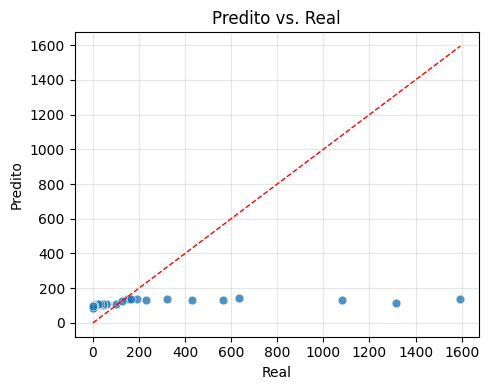

In [39]:
# Predito vs real
plt.figure(figsize=(5,4))
sns.scatterplot(x=y_true, y=y_pred, s=40, alpha=0.8)
mn, mx = np.min([y_true.min(), y_pred.min()]), np.max([y_true.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Real")
plt.ylabel("Predito")
plt.title("Predito vs. Real")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

As predições fora dos folds foram comparadas aos valores reais; o espalhamento em torno da linha y=x quantifica viés e calibração.

O modelo parece estar viesado para uma previsão em torno de 0 e 200, apresentando baixíssima correlaçao entre o real e o previsto.  
Isso indica compressão das predições: o modelo quase não varia a saída e não acompanha a amplitude do alvo , o que caracteriza subajuste/encolhimento para a média e má calibração.

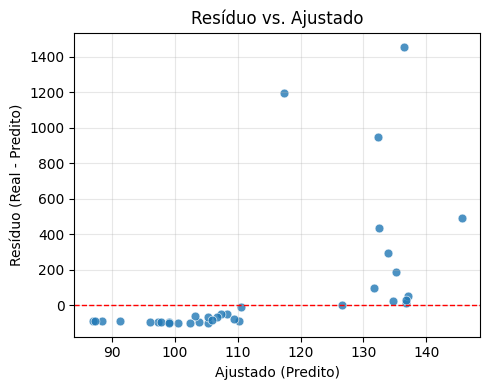

In [40]:
# Resíduo vs. Ajustado
plt.figure(figsize=(5,4))
sns.scatterplot(x=y_pred, y=res, s=40, alpha=0.8)
plt.axhline(0, color="r", ls="--", lw=1)
plt.xlabel("Ajustado (Predito)")
plt.ylabel("Resíduo (Real - Predito)")
plt.title("Resíduo vs. Ajustado")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Resíduo vs. Ajustado mostra o erro em função do valor previsto.

Não parece haver linearidade entre o erro e o valor previsto, mas observa-se que cerca de 20% das previsões com erros mais discrepantes estão acimada da média da previsão.

O padrão indica viés por faixa e heterocedasticidade: o modelo superestima quando o valor previsto é baixo (resíduos negativos) e passa a subestimar quando é alto (resíduos positivos), com a variância do erro abrindo em “leque” à medida que cresce.​  
Em termos visuais: concentração de erros negativos nas faixas baixas e erros positivos muito dispersos nas faixas altas sugerem que o modelo não acompanha as caudas e pode estar subespecificado nessa região.

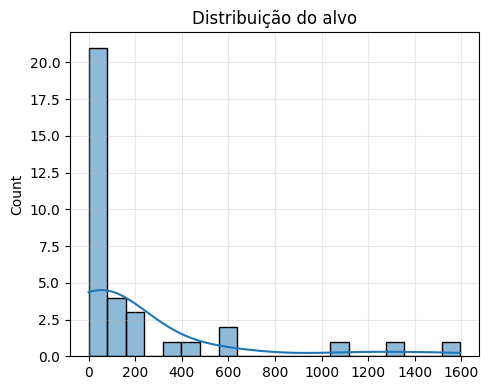

In [41]:
# Distribuição dos resíduos
plt.figure(figsize=(5,4))
sns.histplot(y_true, bins=20, kde=True)
plt.xlabel("")
plt.title("Distribuição do alvo")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

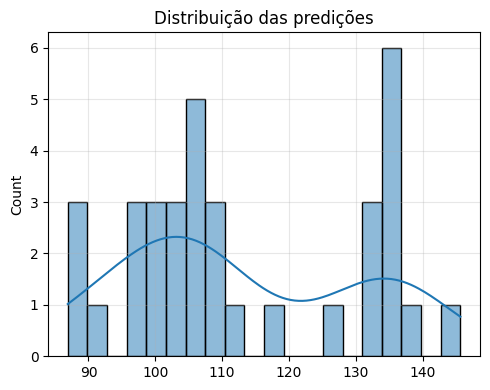

In [42]:
# Distribuição dos resíduos
plt.figure(figsize=(5,4))
sns.histplot(y_pred, bins=20, kde=True)
plt.xlabel("")
plt.title("Distribuição das predições")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

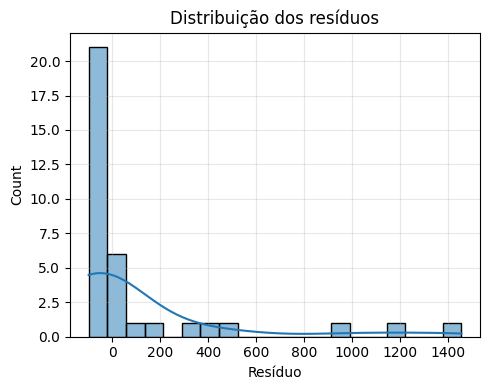

In [43]:
# Distribuição dos resíduos
plt.figure(figsize=(5,4))
sns.histplot(res, bins=20, kde=True)
plt.xlabel("Resíduo")
plt.title("Distribuição dos resíduos")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

* O histograma dos resíduos (OOF) mostra concentração entre −200 e 0, indicando viés de sobreprevisão na maioria das observações, alguns casos de subprevisão moderada (0 a 100) e poucos erros mais dispersos, que poderiam ser considerados outliers em um tamanho amostral mais confiável.
* A distribuição é assimétrica para o lado negativo, consistente com viés por faixa observado no gráfico Resíduo vs. Ajustado; alguns erros mais raros elevam a variabilidade e explicam a diferença entre MAE e RMSE (a seguir).

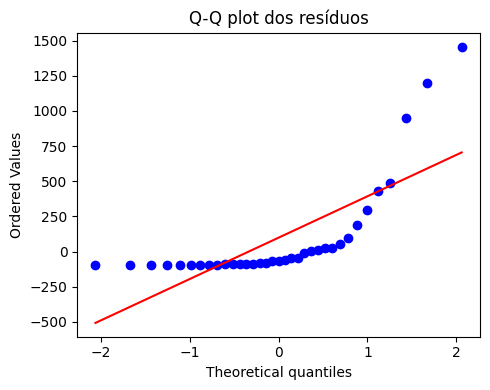

In [44]:
# Q-Q plot dos resíduos
plt.figure(figsize=(5,4))
stats.probplot(res, dist="norm", plot=plt)
plt.title("Q-Q plot dos resíduos")
plt.tight_layout()
plt.show()

* Theoretical quantiles: são os quantis da distribuição normal teórica.
* Ordered values: são os quantis dos resíduos, ordenados.

Se os resíduos seguissem uma distribuição normal, estariam mais próximos da linha de referência.  
O Q-Q plot dos resíduos mostra desvio substancial da normalidade (padrão em 'S' e cauda direita acima da referência), sugerindo erros assimétricos e com cauda pesada, o que afeta a calibragem de intervalos e testes que assumem normalidade.

In [45]:
# MAE OOF e R-quadrado
mae_oof = mean_absolute_error(y_true, y_pred)
print(f' MAE (OOF): {mae_oof}')

rmse_oof = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE (OOF): {rmse_oof}')

r2 = r2_score(y_true, y_pred)
print(f'        R²: {r2}')

 MAE (OOF): 200.0684790475028
RMSE (OOF): 384.57831039922826
        R²: -0.017637979847209273


Erro absoluto Médio (fora dos folds):  
As predições se desviam em média 200 CPA (MAE=200.07) do valor real em validação fora da amostra.

Raiz do Erro Quadrático Médio (fora dos folds):  
Esta medida é mais sensível a outliers que o MAE. Um resultado acima de 50% maior (RMSE=384.58) indica outliers puxandoodesempenho para baixo.

O R² OOF foi -0.018, indicando desempenho marginalmente inferior ao preditor da média, consistente com a compressão das predições observada no gráfico Predito vs. Real e com a heterocedasticidade nos resíduos; reportamos também MAE OOF para interpretar o erro em unidades de cliques.